# Inspect YOLOv2 Model

In [1]:
import os
from pprint import pprint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import VOCDetection, wrap_dataset_for_transforms_v2
from torchvision.transforms import v2
from torchvision.tv_tensors._dataset_wrapper import VOC_DETECTION_CATEGORIES, VOC_DETECTION_CATEGORY_TO_IDX
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert, clip_boxes_to_image, nms, batched_nms
from torchmetrics.detection import MeanAveragePrecision
from torchinfo import summary
import sys
sys.path.append('../')
from models.yolov2 import Yolov2Config, Yolov2
from dataloaders.voc import Resize, Voc2Yolov2
from evaluator import DetEvaluator
from torch.utils.tensorboard import SummaryWriter
# palette is a list of color tuples, which is used for visualization.
palette =  [(106, 0, 228), (119, 11, 32), (165, 42, 42), (0, 0, 192),
            (197, 226, 255), (0, 60, 100), (0, 0, 142), (255, 77, 255),
            (153, 69, 1), (120, 166, 157), (0, 182, 199),
            (0, 226, 252), (182, 182, 255), (0, 0, 230), (220, 20, 60),
            (163, 255, 0), (0, 82, 0), (3, 95, 161), (0, 80, 100),
            (183, 130, 88)]

## Inspect structure

In [16]:
img_h, img_w = 448, 448
n_class = 20
n_box_per_cell = 5

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    n_box_per_cell=n_box_per_cell,
)

n_grid_h, n_grid_w = img_h * 13 // 416, img_w * 13 // 416

model_config = Yolov2Config(**model_args)
model = Yolov2(model_config)

batch_size = 1
summary(model, input_size=[(batch_size, 3, img_h, img_w), (batch_size, n_grid_h, n_grid_w, n_box_per_cell, 6)], device='cuda',
        col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"), verbose=2,
        depth=4, row_settings=("depth", "var_names"));

number of parameters: 67.14M
Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds                 Trainable
Yolov2 (Yolov2)                               [1, 3, 448, 448]          [1, 14, 14, 5, 25]        --                        --                        --                        True
├─Darknet19Backbone (backbone): 1-1           [1, 3, 448, 448]          [1, 1024, 14, 14]         --                        --                        --                        True
│    └─conv1.conv.weight                                                                          ├─864                     [32, 3, 3, 3]
│    └─conv1.bn.weight                                                                            ├─32                      [32]
│    └─conv1.bn.bias                                                                              ├─32                      [32]
│    └─conv2.conv.weight   

In [3]:
writer = SummaryWriter()
imgs = torch.randn(batch_size, 3, img_h, img_w)
targets = torch.randn(batch_size, n_grid_h, n_grid_w, n_box_per_cell, 6)
model.to('cpu')
writer.add_graph(model, [imgs, targets])
writer.close()

/home/alvin/Projects/Alvin/yolov2/tests/../models/yolov2.py:197: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  anchors = torch.tensor(self.config.anchors, dtype=dtype, device=device)  # size(n_box_per_cell, 2)
/home/alvin/Projects/Alvin/yolov2/tests/../models/yolov2.py:198: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  loss = torch.tensor(0.0, dtype=dtype, device=device)
/home/alvin/Projects/Alvin/yolov2/tests/../models/yolov2.py:199: TracerWarning: torch.tensor results are reg

In [7]:
logits, loss, _, _, _, _, _ = model(imgs, targets)
print(logits.shape)
print(loss.shape)

torch.Size([1, 14, 14, 5, 25])
torch.Size([])


## Inspect state_dict

In [8]:
import tempfile

# Save state_dict as a temporary file
with tempfile.NamedTemporaryFile(suffix='.pth') as temp_file:
    torch.save(model.state_dict(), temp_file.name)
    state_dict = torch.load(temp_file.name)

# Print the keys of the state_dict
for key in state_dict.keys():
    print(key)


backbone.conv1.conv.weight
backbone.conv1.bn.weight
backbone.conv1.bn.bias
backbone.conv1.bn.running_mean
backbone.conv1.bn.running_var
backbone.conv1.bn.num_batches_tracked
backbone.conv2.conv.weight
backbone.conv2.bn.weight
backbone.conv2.bn.bias
backbone.conv2.bn.running_mean
backbone.conv2.bn.running_var
backbone.conv2.bn.num_batches_tracked
backbone.conv3.conv.weight
backbone.conv3.bn.weight
backbone.conv3.bn.bias
backbone.conv3.bn.running_mean
backbone.conv3.bn.running_var
backbone.conv3.bn.num_batches_tracked
backbone.conv4.conv.weight
backbone.conv4.bn.weight
backbone.conv4.bn.bias
backbone.conv4.bn.running_mean
backbone.conv4.bn.running_var
backbone.conv4.bn.num_batches_tracked
backbone.conv5.conv.weight
backbone.conv5.bn.weight
backbone.conv5.bn.bias
backbone.conv5.bn.running_mean
backbone.conv5.bn.running_var
backbone.conv5.bn.num_batches_tracked
backbone.conv6.conv.weight
backbone.conv6.bn.weight
backbone.conv6.bn.bias
backbone.conv6.bn.running_mean
backbone.conv6.bn.runnin

## Inspect gradients

In [16]:
class DebugDependencyYolov2(Yolov2):
    """Yolov2 with dummy loss function for debugging dependencies."""
    def __init__(self, loss_img_idx, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_img_idx = loss_img_idx

    def _compute_loss(self, logits: Tensor, targets: Tensor) -> Tensor:
        """
        Compute the dummy loss as sum of all outputs of img i.
        Args:
            logits (Tensor): size(N, n_grid_h, n_grid_w, n_box_per_cell, (5 + n_class))
            targets (Tensor): size(N, n_grid_h, n_grid_w, n_box_per_cell, 6)
        Returns:
            loss (Tensor): size(,)
            loss_noobj (Tensor): size(,)
            loss_obj (Tensor): size(,)
            loss_class (Tensor): size(,)
            loss_xy (Tensor): size(,)
            loss_wh (Tensor): size(,)
        """
        return torch.sum(logits[self.loss_img_idx]), None, None, None, None, None


To verify no inadvertently mix information across the batch dimension, run the backward pass all the way to the input, and ensure that you get a non-zero gradient only on the i-th input.

In [17]:
batch_size = 5
X = torch.randn(batch_size, 3, img_h, img_w, requires_grad=True)
Y =  targets = torch.randn(batch_size, n_grid_h, n_grid_w, n_box_per_cell, 6)

In [18]:
print("Setup:")
torch.manual_seed(1337);  # since kaiming_normal_ weight init is random
loss_img_idx = 2
debug_dependency_model = DebugDependencyYolov2(loss_img_idx, model_config)
debug_dependency_model.eval()  # since batchnorm will mixed variables between images in a batch

optimizer_type = 'adam'
learning_rate = 3e-4
beta1 = 0.9
beta2 = 0.999
weight_decay = 5e-4
device_type = 'cpu'
use_fused = False
optimizer = debug_dependency_model.configure_optimizers(optimizer_type, learning_rate, (beta1, beta2), weight_decay, device_type, use_fused)

print("\n\nForward pass:")
logits, loss, _, _, _, _, _ = debug_dependency_model(X, Y)
print(f"{logits.shape=}")
print(f"{loss=}")

print("\n\nBackward pass & Gradients of X::")
optimizer.zero_grad(set_to_none=True)
X.grad = None  # zero out X gradients
loss.backward()

print(f"{X.grad.shape=}")
for idx_img in range(batch_size):
    print(f"Zero gradient of {idx_img}'th img: {torch.all(X.grad[idx_img]==0)}")

print("\n\nOptimizer step:")
optimizer.step()
print(f"Loss after optimized: {debug_dependency_model(X, Y)[1]}")

Setup:
number of parameters: 67.14M
num decayed parameter tensors: 22, with 67,116,896 parameters
num non-decayed parameter tensors: 43, with 20,669 parameters
using fused Adam: False


Forward pass:
logits.shape=torch.Size([5, 14, 14, 5, 25])
loss=tensor(-277.3766, grad_fn=<SumBackward0>)


Backward pass & Gradients of X::
X.grad.shape=torch.Size([5, 3, 448, 448])
Zero gradient of 0'th img: True
Zero gradient of 1'th img: True
Zero gradient of 2'th img: False
Zero gradient of 3'th img: True
Zero gradient of 4'th img: True


Optimizer step:
Loss after optimized: -1272555.5


## Inspect output, post-processing, prediction

In [7]:
from_ckpt = '../out/yolov2_nano-voc/20240317-230626/ckpt_last.pt'
checkpoint = torch.load(from_ckpt, map_location='cuda')
state_dict = checkpoint['model']

config = checkpoint['config']
img_h, img_w = config['img_h'], config['img_w']  # try: (320, 352, 384, 416, 448, 480, 512, 544, 576, 608)
n_class = config['n_class']
anchors = config['anchors']
n_box_per_cell = config['n_box_per_cell']

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    anchors=anchors,
    n_box_per_cell=n_box_per_cell,
)
model_config = Yolov2Config(**model_args)
model = Yolov2(model_config)

model.load_state_dict(state_dict)
model.to('cuda');

pprint(config)

number of parameters: 67.14M
{'always_save_checkpoint': False,
 'anchors': ((1.08, 1.19),
             (3.42, 4.41),
             (6.63, 11.38),
             (9.42, 5.11),
             (16.62, 10.52)),
 'batch_size': 2,
 'beta1': 0.9,
 'beta2': 0.999,
 'brightness': 0.0,
 'compile': False,
 'contrast': 0.0,
 'crop_scale': 1.0,
 'dataset_name': 'nano_voc',
 'decay_lr': False,
 'degrees': 0.0,
 'device': 'cuda',
 'dtype': 'bfloat16',
 'eval_interval': 2,
 'eval_iters': 1,
 'eval_only': False,
 'fill': (123.0, 117.0, 104.0),
 'flip_p': 0.0,
 'from_ckpt': 'saved/darknet19-448_imagenet2012/20240303-055517/ckpt_last.pt',
 'grad_clip': 0.0,
 'gradient_accumulation_steps': 1,
 'hue': 0.0,
 'img_h': 416,
 'img_w': 416,
 'imgs_mean': (0.0, 0.0, 0.0),
 'imgs_std': (1.0, 1.0, 1.0),
 'init_from': 'backbone',
 'lambda_class': 1.0,
 'lambda_coord': 5.0,
 'lambda_noobj': 0.5,
 'lambda_obj': 1.0,
 'learning_rate': 1e-07,
 'letterbox': True,
 'log_interval': 1,
 'lr_decay_iters': 100000,
 'max_iters': 1

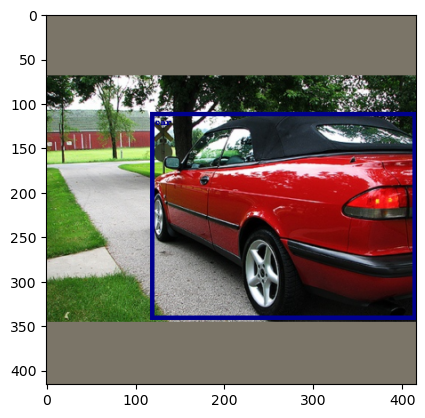

In [8]:
letterbox = config['letterbox']
fill = config['fill']
imgs_mean, imgs_std = config['imgs_mean'], config['imgs_std']

transforms = v2.Compose([
    v2.ToImage(),
    Resize(size=(img_h, img_w), letterbox=letterbox, fill=fill, antialias=True),
    v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=imgs_mean, std=imgs_std),
    Voc2Yolov2(n_box_per_cell=n_box_per_cell),
])
dataset = VOCDetection(root='../data/voc', year='2007', image_set='trainval', download=False, transforms=transforms)  # FIXME: change image_set back to 'test' when nano-voc is finished
dataset_v2 = wrap_dataset_for_transforms_v2(dataset, target_keys=['boxes', 'labels'])

img, y, y_supp = dataset_v2[1]
labels = [VOC_DETECTION_CATEGORIES[idx+1] for idx in y_supp['labels']]  # +1 because background 0 is removed in y_supp
img_gt = draw_bounding_boxes(v2.functional.to_dtype(img, torch.uint8, scale=True), labels=labels, boxes=y_supp['boxes'],
                             colors=[palette[idx] for idx in y_supp['labels']], width=5)
plt.imshow(img_gt.permute(1, 2, 0).numpy())
plt.show()

mAP only consider the classes that are in the ground truth of the entire dataset

grid (4, 7)
  class: horse (0.99)
  box 2 confidence: 1.00, probability: 0.9995


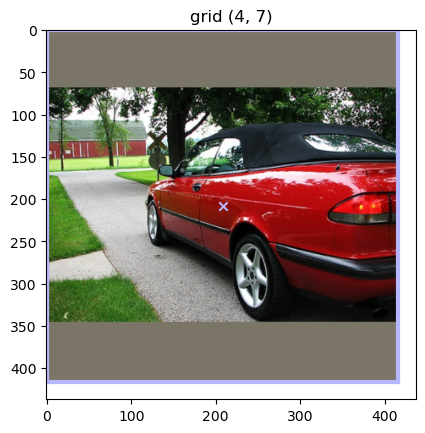

grid (5, 5)
  class: horse (1.00)
  box 4 confidence: 1.00, probability: 0.9991


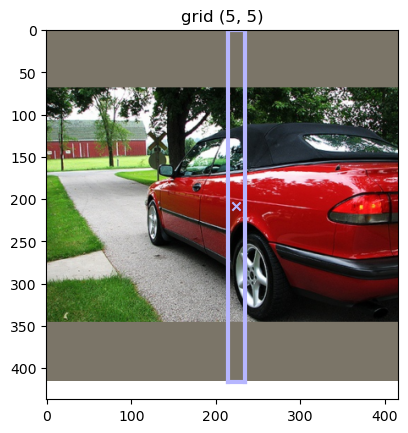

grid (6, 5)
  class: person (0.99)
  box 2 confidence: 1.00, probability: 0.9922


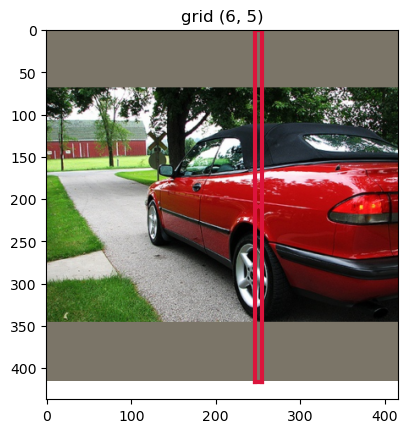

grid (6, 7)
  class: motorbike (1.00)
  box 4 confidence: 1.00, probability: 0.9921


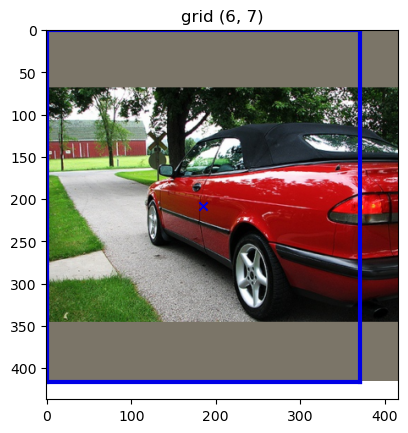

grid (7, 8)
  class: bus (0.99)
  box 4 confidence: 1.00, probability: 0.9918


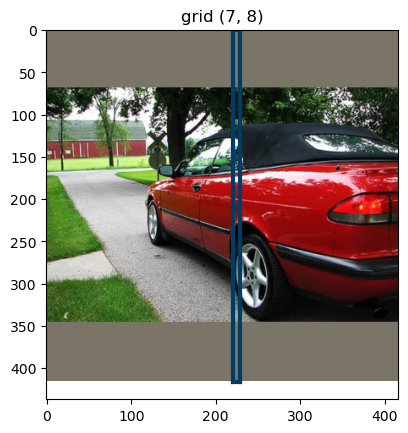

grid (8, 7)
  class: car (0.99)
  box 4 confidence: 1.00, probability: 0.9910


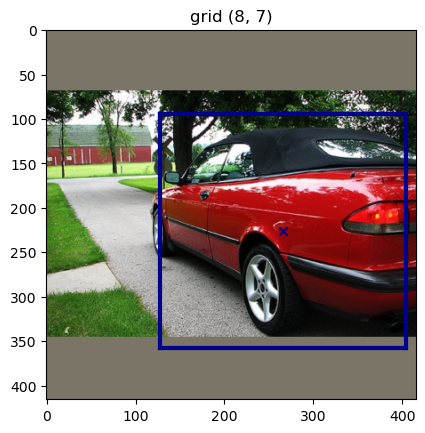

In [11]:
batch_size = 1
prob_thresh = 0.99
nms_iou_thresh = 0.5
n_grid_h, n_grid_w = img_h * 13 // 416, img_w * 13 // 416

with torch.inference_mode():
    imgs = torch.unsqueeze(img, dim=0)
    imgs = imgs.to('cuda')
    model.eval()
    logits, loss, _, _, _, _, _ = model(imgs)
    logits = logits.to('cpu')

    for logits_per_img in logits:
        grid_y, grid_x, idx_box, idx_class= torch.meshgrid(torch.arange(n_grid_h), torch.arange(n_grid_w),
                                                           torch.arange(n_box_per_cell), torch.arange(n_class),
                                                           indexing='ij')
        logits_class = logits_per_img[:, :, :, 5:]
        prob_class = F.softmax(logits_class, dim=-1)

        sigmoid_t_o = logits_per_img[grid_y, grid_x, idx_box, 4]
        conf = sigmoid_t_o

        prob = prob_class * conf
        mask = (prob > prob_thresh) & (conf > 0.0)
        grid_y, grid_x, idx_box, idx_class, prob = grid_y[mask], grid_x[mask], idx_box[mask], idx_class[mask], prob[mask]

        anchors_tensor = torch.tensor(anchors)
        anchors_w, anchors_h = anchors_tensor[idx_box, 0], anchors_tensor[idx_box, 1]

        sigmoid_t_x, sigmoid_t_y = logits_per_img[grid_y, grid_x, idx_box, 0], logits_per_img[grid_y, grid_x, idx_box, 1]
        t_w, t_h = logits_per_img[grid_y, grid_x, idx_box, 2], logits_per_img[grid_y, grid_x, idx_box, 3]

        cx, cy = (sigmoid_t_x + grid_x) / n_grid_w * img_w, (sigmoid_t_y + grid_y) / n_grid_h * img_h
        w, h = torch.exp(t_w) * anchors_w / n_grid_w * img_w, torch.exp(t_h) * anchors_h / n_grid_h * img_h
        coord = torch.stack((cx, cy, w, h), dim=-1)

        boxes = clip_boxes_to_image(box_convert(coord, in_fmt='cxcywh', out_fmt='xyxy'), size=(img_h, img_w))  # TODO: clip boxes to actual image region before padding
        scores = prob
        classes = idx_class

        boxes, scores = boxes.to(torch.float32), scores.to(torch.float32)
        keep = batched_nms(boxes, scores, classes, nms_iou_thresh)  # don't work for BFloat16
        boxes, scores, classes = boxes[keep], scores[keep], classes[keep]

        n_pred = 0
        for grid_y_per_box, grid_x_per_box, idx_box_per_box, cls, prob_class_per_box, conf_per_box, prob_per_box, coord_per_box \
            in zip(grid_y, grid_x, idx_box, classes, prob_class[mask], conf[mask], scores, boxes):

            print(f"grid ({grid_y_per_box}, {grid_x_per_box})")
            print(f"  class: {VOC_DETECTION_CATEGORIES[cls+1]} ({prob_class_per_box:.2f})")
            print(f"  box {idx_box_per_box} confidence: {conf_per_box:.2f}, probability: {prob_per_box:.4f}")
            plt.title(f"grid ({grid_y_per_box}, {grid_x_per_box})")
            plt.imshow(img.permute(1, 2, 0))

            x1, y1, x2, y2 = coord_per_box
            plt.scatter((x1 + x2) // 2, (y1 + y2) // 2, marker='x', color=np.array(palette[cls], dtype=float) / 255.0)
            plt.plot([x1, x2], [y1, y1], color=np.array(palette[cls], dtype=float) / 255.0, linewidth=3)
            plt.plot([x1, x2], [y2, y2], color=np.array(palette[cls], dtype=float) / 255.0, linewidth=3)
            plt.plot([x1, x1], [y1, y2], color=np.array(palette[cls], dtype=float) / 255.0, linewidth=3)
            plt.plot([x2, x2], [y1, y2], color=np.array(palette[cls], dtype=float) / 255.0, linewidth=3)
            plt.show()

            n_pred += 1
            if n_pred > 20:
                raise ValueError("Too much predictions. Stopped to prevent too much plotting.")


## Inspect mAP

In [5]:
from_ckpt = '../out/yolov2_nano-voc/20240317-230626/ckpt_last.pt'
checkpoint = torch.load(from_ckpt, map_location='cuda')
state_dict = checkpoint['model']

config = checkpoint['config']
img_h, img_w = config['img_h'], config['img_w']  # try: (320, 352, 384, 416, 448, 480, 512, 544, 576, 608)
n_grid_h, n_grid_w = img_h * 13 // 416, img_w * 13 // 416
n_class = config['n_class']
anchors = config['anchors']
n_box_per_cell = config['n_box_per_cell']

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    anchors=anchors,
    n_box_per_cell=n_box_per_cell,
)
model_config = Yolov2Config(**model_args)
model = Yolov2(model_config)

model.load_state_dict(state_dict)
model.to('cuda');

print(f"{checkpoint['iter_num']=}")

number of parameters: 67.14M
checkpoint['iter_num']=1600


In [6]:
batch_size = 2#256  # FIXME: enlarge batch_size when nano-voc is finished
letterbox = config['letterbox']
fill = config['fill']
imgs_mean, imgs_std = config['imgs_mean'], config['imgs_std']

transforms = v2.Compose([
    v2.ToImage(),
    Resize(size=(img_h, img_w), letterbox=letterbox, fill=fill, antialias=True),
    v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=imgs_mean, std=imgs_std),
])
dataset = VOCDetection('../data/voc', year='2007', image_set='trainval', transforms=transforms)  # FIXME: change image_set back to 'test' when nano-voc is finished
dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=['boxes', 'labels'])
dataset = Subset(dataset, range(batch_size))  # FIXME: remove this line when nano-voc is finished

voc2yolov2_transform = Voc2Yolov2(n_box_per_cell=n_box_per_cell)
def collate_fn(batch):
    xs, ys, y_supps = [], [], []
    for x, y_supp in batch:
        xs.append(x)
        y_supps.append(y_supp)
    for idx_img, (x, y_supp) in enumerate(zip(xs, y_supps)):
        x, y, y_supp = voc2yolov2_transform(x, y_supp)
        xs[idx_img] = x
        ys.append(y)
        y_supps[idx_img] = y_supp
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    return xs, ys, y_supps
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=True, collate_fn=collate_fn)
print(f"dataset: {len(dataloader.dataset)} samples, {len(dataloader)} batches")

dataset: 2 samples, 1 batches


In [7]:
prob_thresh = 0.001
nms_iou_thresh = 0.5
# Compute mAP by torchmetrics
metric = MeanAveragePrecision(iou_type='bbox')#, extended_summary=True)  # extended_summary=True cannot be used with metric.plot()

with torch.inference_mode():
    model.eval()
    for x, y, y_supp in dataloader:
        x, y = x.to('cuda'), y.to('cuda')
        device = x.device
        logits, _, _, _, _, _, _ = model(x, y)

        preds_for_eval, targets_for_eval = [], []
        for logits_per_img, y_supp in zip(logits, y_supp):
            grid_y, grid_x, idx_box, idx_class= torch.meshgrid(torch.arange(n_grid_h, device=device),
                                                               torch.arange(n_grid_w, device=device),
                                                               torch.arange(n_box_per_cell, device=device),
                                                               torch.arange(n_class, device=device),
                                                               indexing='ij')
            logits_class = logits_per_img[:, :, :, 5:]
            prob_class = F.softmax(logits_class, dim=-1)

            sigmoid_t_o = logits_per_img[grid_y, grid_x, idx_box, 4]
            conf = sigmoid_t_o

            prob = prob_class * conf
            mask = (prob > prob_thresh) & (conf > 0.0)
            grid_y = grid_y[mask]
            grid_x = grid_x[mask]
            idx_box = idx_box[mask]
            idx_class = idx_class[mask]
            prob = prob[mask]

            anchors_tensor = torch.tensor(anchors, device=device)
            anchors_w = anchors_tensor[idx_box, 0]
            anchors_h = anchors_tensor[idx_box, 1]

            sigmoid_t_x = logits_per_img[grid_y, grid_x, idx_box, 0]
            sigmoid_t_y = logits_per_img[grid_y, grid_x, idx_box, 1]
            t_w = logits_per_img[grid_y, grid_x, idx_box, 2]
            t_h = logits_per_img[grid_y, grid_x, idx_box, 3]

            cx = (sigmoid_t_x + grid_x) / n_grid_w * img_w
            cy = (sigmoid_t_y + grid_y) / n_grid_h * img_h
            w = torch.exp(t_w) * anchors_w / n_grid_w * img_w
            h = torch.exp(t_h) * anchors_h / n_grid_h * img_h
            coord = torch.stack((cx, cy, w, h), dim=-1)

            boxes = clip_boxes_to_image(box_convert(coord, in_fmt='cxcywh', out_fmt='xyxy'),
                                        size=(img_h, img_w))
            scores = prob
            classes = idx_class

            boxes, scores = boxes.to(torch.float32), scores.to(torch.float32)
            keep = batched_nms(boxes, scores, classes, nms_iou_thresh)  # don't work for BFloat16

            boxes = boxes[keep]
            scores = scores[keep]
            classes = classes[keep]

            preds_for_eval.append(dict(boxes=boxes, scores=scores, labels=classes))
            targets_for_eval.append(dict(boxes=y_supp['boxes'].to(device), labels=y_supp['labels'].to(device)))

        metric.update(preds_for_eval, targets_for_eval)

    print(metric.compute())  # 'map_50': tensor(1.), 0.3s

{'map': tensor(0.6497), 'map_50': tensor(1.), 'map_75': tensor(0.8574), 'map_small': tensor(0.7000), 'map_medium': tensor(0.5891), 'map_large': tensor(0.7000), 'mar_1': tensor(0.4100), 'mar_10': tensor(0.6800), 'mar_100': tensor(0.6800), 'mar_small': tensor(0.7000), 'mar_medium': tensor(0.6500), 'mar_large': tensor(0.7000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], dtype=torch.int32)}


/home/alvin/miniconda3/envs/yolo/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


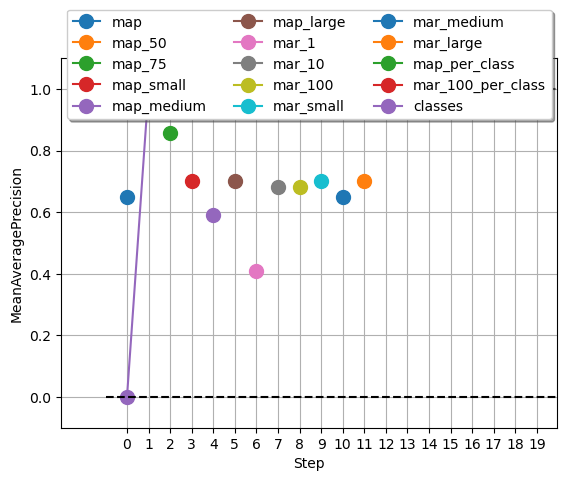

In [8]:
fig_, ax_ = metric.plot()  # plot() cannot be used with extended_summary=True
plt.show()

mAP: 99.50%
mean precision of all classes at max F1: 81.27%
mean recall of all classes at max F1: 100.00%


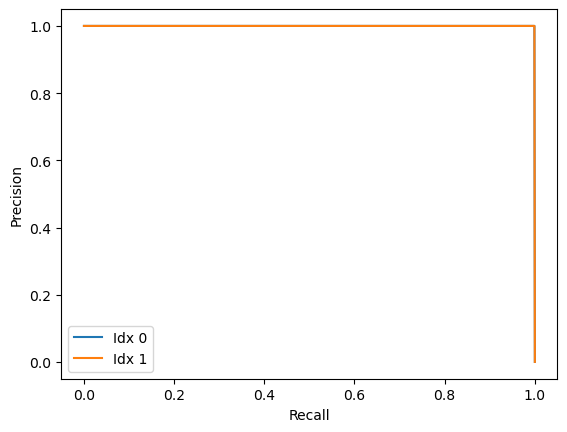

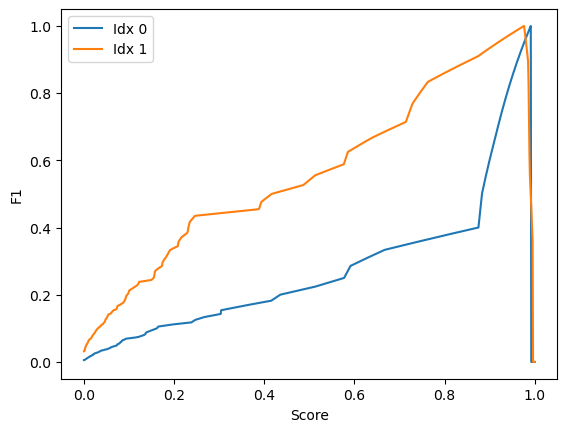

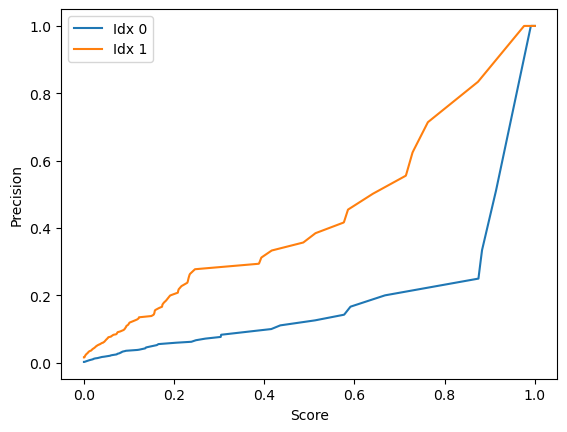

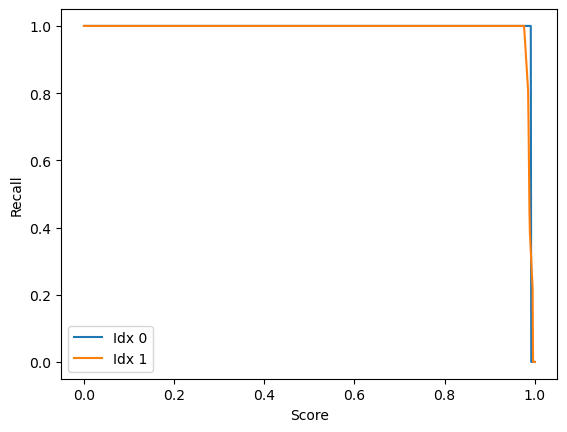

In [9]:
prob_thresh = 0.001
nms_iou_thresh = 0.5
# Compute mAP by custom fast but simple evaluator
metric = DetEvaluator()

with torch.inference_mode():
    model.eval()
    for x, y, y_supp in dataloader:
        x, y = x.to('cuda'), y.to('cuda')
        device = x.device
        logits, _, _, _, _, _, _ = model(x, y)

        preds_for_eval, targets_for_eval = [], []
        for logits_per_img, y_supp in zip(logits, y_supp):
            grid_y, grid_x, idx_box, idx_class= torch.meshgrid(torch.arange(n_grid_h, device=device),
                                                               torch.arange(n_grid_w, device=device),
                                                               torch.arange(n_box_per_cell, device=device),
                                                               torch.arange(n_class, device=device),
                                                               indexing='ij')
            logits_class = logits_per_img[:, :, :, 5:]
            prob_class = F.softmax(logits_class, dim=-1)

            sigmoid_t_o = logits_per_img[grid_y, grid_x, idx_box, 4]
            conf = sigmoid_t_o

            prob = prob_class * conf
            mask = (prob > prob_thresh) & (conf > 0.0)
            grid_y = grid_y[mask]
            grid_x = grid_x[mask]
            idx_box = idx_box[mask]
            idx_class = idx_class[mask]
            prob = prob[mask]

            anchors_tensor = torch.tensor(anchors, device=device)
            anchors_w = anchors_tensor[idx_box, 0]
            anchors_h = anchors_tensor[idx_box, 1]

            sigmoid_t_x = logits_per_img[grid_y, grid_x, idx_box, 0]
            sigmoid_t_y = logits_per_img[grid_y, grid_x, idx_box, 1]
            t_w = logits_per_img[grid_y, grid_x, idx_box, 2]
            t_h = logits_per_img[grid_y, grid_x, idx_box, 3]

            cx = (sigmoid_t_x + grid_x) / n_grid_w * img_w
            cy = (sigmoid_t_y + grid_y) / n_grid_h * img_h
            w = torch.exp(t_w) * anchors_w / n_grid_w * img_w
            h = torch.exp(t_h) * anchors_h / n_grid_h * img_h
            coord = torch.stack((cx, cy, w, h), dim=-1)

            boxes = clip_boxes_to_image(box_convert(coord, in_fmt='cxcywh', out_fmt='xyxy'),
                                        size=(img_h, img_w))
            scores = prob
            classes = idx_class

            boxes, scores = boxes.to(torch.float32), scores.to(torch.float32)
            keep = batched_nms(boxes, scores, classes, nms_iou_thresh)  # don't work for BFloat16

            boxes = boxes[keep]
            scores = scores[keep]
            classes = classes[keep]

            preds_for_eval.append(dict(boxes=boxes, scores=scores, labels=classes))
            targets_for_eval.append(dict(boxes=y_supp['boxes'].to(device), labels=y_supp['labels'].to(device)))

        metric.update(preds_for_eval, targets_for_eval)

    results = metric.compute()
    print(f"mAP: {results['map_50']:.2%}")
    print(f"mean precision of all classes at max F1: {results['mp']:.2%}")
    print(f"mean recall of all classes at max F1: {results['mr']:.2%}")

    curves = results['curves']
    for x_curve, y_curves, x_label, y_label in curves:
        for idx, y_curve in enumerate(y_curves):
            plt.plot(x_curve, y_curve, label=f"Idx {idx}")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()